In [171]:
from scipy import stats
from scipy.special import gamma
from scipy.stats import expon
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import math
from matplotlib import pyplot as plt
%matplotlib inline
import corner
from glob import glob
import os

In [18]:
def alpha_lgprior(alpha, beta):
    if alpha + beta < 0:
        return -np.inf
    if alpha < 0:
        return -np.inf
    if alpha + beta > 20:
        return -np.inf
    if alpha > 20:
        return -np.inf
    return 0


def alpha_lglike(samples, alpha, beta):
    return len(samples) * (math.log(gamma(alpha + beta)) - math.log(gamma(alpha))) + np.sum(alpha * np.log(samples))


# log-posterior for P(alpha | beta, samples)
def alpha_lgprob(alpha, beta, samples):
    # l(alpha | beta, samples) ~ l(alpha, beta) + l(samples | alpha, beta)
    return alpha_lgprior(alpha, beta) + alpha_lglike(samples, alpha, beta)


def get_alpha(alpha, beta, samples):
    # Draw new alpha from proposal distribution
    prop = expon(scale=4)
    
    new_alpha = prop.rvs(1)[0]
    
    prob_new_alpha = prop.pdf(new_alpha)
    prob_old_alpha = prop.pdf(alpha)
    
    # MH-Step
    # a = a_1 * a_2
    # a_1 = P(new) / P(old)
    # a_2 = Q(old) / Q(new)
    # Accept with prob a if a <= 1
    # lg(a) = lg(a_1) + lg(a2)
    # lg(a) = lg(P(new)) - lg(P(old)) + lg(Q(old)) - lg(Q(new))
    # Accept with prob a if lg(a) <= 0
    
    lg_a1 = alpha_lgprob(new_alpha, beta, samples) - alpha_lgprob(alpha, beta, samples)
    
    lg_a2 = math.log(prob_old_alpha) - math.log(prob_new_alpha)
    
    lg_a = lg_a1 + lg_a2

    if lg_a > 1:
        return new_alpha
    else:
        lg_r = math.log(np.random.uniform())
        if lg_r < lg_a:
            return new_alpha
        else:
            return alpha

In [19]:
def beta_lgprior(alpha, beta):
    if alpha + beta < 0:
        return -np.inf
    if beta < 0:
        return -np.inf
    if alpha + beta > 20:
        return -np.inf
    if beta > 20:
        return -np.inf
    return 0


def beta_lglike(samples, alpha, beta):
    return len(samples) * (math.log(gamma(alpha + beta)) - math.log(gamma(beta))) + np.sum(beta * np.log(1 - samples))


# log-posterior for P(alpha | beta, samples)
def beta_lgprob(alpha, beta, samples):        
    # l(beta | alpha, samples) ~ l(alpha, beta) + l(samples | alpha, beta)
    return beta_lgprior(alpha, beta) + beta_lglike(samples, alpha, beta)


def get_beta(alpha, beta, samples):    
    # Draw new beta from proposal distribution
    prop = expon(scale=4)
    
    new_beta = prop.rvs(1)[0]
    
    prob_new_beta = prop.pdf(new_beta)
    prob_old_beta = prop.pdf(beta)
    
    # MH-Step
    # a = a_1 * a_2
    # a_1 = P(new) / P(old)
    # a_2 = Q(old) / Q(new)
    # Accept with prob a if a <= 1
    # lg(a) = lg(a_1) + lg(a2)
    # lg(a) = lg(P(new)) - lg(P(old)) + lg(Q(old)) - lg(Q(new))
    # Accept with prob a if lg(a) <= 0
    
    lg_a1 = beta_lgprob(alpha, new_beta, samples) - beta_lgprob(alpha, beta, samples)
        
    lg_a2 = math.log(prob_old_beta) - math.log(prob_new_beta)
            
    lg_a = lg_a1 + lg_a2

    if lg_a > 0:
        return new_beta
    else:
        lg_r = math.log(np.random.uniform())
        if lg_r < lg_a:
            return new_beta
        else:
            return beta

In [37]:
def load_data():
    ret_data = []
    
    pulsars = glob("../../AAS/thinned_chains/pars_M2_SINI/*")
    for pulsar in pulsars:
        chain = os.path.join(pulsar, "chain_burn_0.5_thin_10.txt")
        chain_data = np.genfromtxt(chain)
        cosi_data = chain_data[:, 2]
        ret_data.append(cosi_data)
        
    return np.asarray(ret_data)

In [129]:
def thin_data(measurements, num_points=5000):
    ret_data = []
    for measurement in measurements:
        if len(measurement) < num_points:
            ret_data.append(measurement)
            continue
        
        ret_data.append(measurement[::int(len(measurement) / num_points)])
    return np.asarray(ret_data)

In [ ]:
cosi_vals = load_data()

In [71]:
def get_samples(alpha, beta, measurements):
    guess = stats.beta(alpha, beta)
    # Draw new samples from P(COSI_i | alpha, beta)
    N = measurements.shape[0]
    samples = np.zeros(N)
    
    for i, measurement in enumerate(measurements):
        probs = guess.pdf(measurement)
        probs /= np.sum(probs)
        samples[i] = np.random.choice(measurement, p=probs)
    
    return samples

In [137]:
def sample(measurements, niter=1000, guess_alpha=1.0, guess_beta=1.0):
    alphas = np.zeros(niter)
    betas = np.zeros(niter)
    
    alphas[0] = guess_alpha
    betas[0] = guess_beta

    # Gibbs Sampling
    for i in range(1, niter):
        if i % 100 == 0:
            print "{0:0.1f}% Done                   \r".format(100. * i / float(niter)),

        # Draw x_i ~ P(x_i | alpha_i-1, beta_i-1)
        samples = get_samples(alphas[i - 1], betas[i - 1], measurements)
        
        # Draw alpha_i ~ P(alpha_i | x_i, beta_i-1)
        alphas[i] = get_alpha(alphas[i - 1], betas[i - 1], samples)
        
        # Draw beta_i ~ P(beta_i | x_i, alpha_i)
        betas[i] = get_beta(alphas[i], betas[i - 1], samples)
    
    return alphas, betas

In [165]:
thinned_data = thin_data(cosi_vals)
alphas, betas = sample(thinned_data, niter=10000)

In [163]:
def plot_sampling(measurements, alphas, betas, pop_alpha, pop_beta, burn_in=0.5, thin=0.1):
    alphas_good = alphas[int(burn_in * len(alphas))::int(1/thin)]
    betas_good = betas[int(burn_in * len(betas))::int(1/thin)]

    best_guess_alpha = np.median(alphas_good)
    best_guess_beta = np.median(betas_good)
    
    plt.hist([np.median(measurement) for measurement in measurements], normed=True, label="Data")
    plt.plot(np.linspace(0, 1, 100), stats.beta(best_guess_alpha, best_guess_beta).pdf(np.linspace(0, 1, 100)), label="Guess")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    alpha_beta_corner = np.vstack((alphas_good, betas_good)).T
    try:
        figure = corner.corner(alpha_beta_corner, quantiles=[0.16, 0.5, 0.84])
        ndim = 2
        # Extract the axes
        axes = np.array(figure.axes).reshape((ndim, ndim))

        value1 = np.asarray([pop_alpha, pop_beta])

        # Loop over the diagonal
        for i in range(ndim):
            ax = axes[i, i]
            ax.axvline(value1[i], color="g")

        # Loop over the histograms
        for yi in range(ndim):
            for xi in range(yi):
                ax = axes[yi, xi]
                ax.axvline(value1[xi], color="g")
                ax.axhline(value1[yi], color="g")
                ax.plot(value1[xi], value1[yi], "sg")
    except:
        print "Cannot corner plot"
    plt.show()

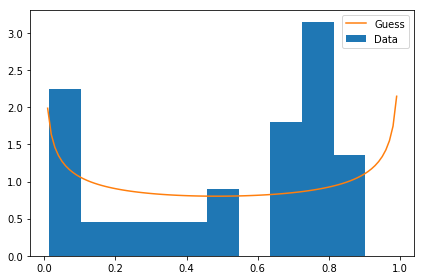

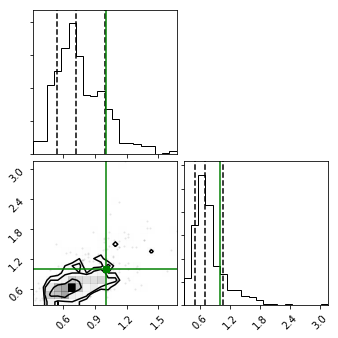

In [174]:
plot_sampling(thinned_data, alphas, betas, 1, 1)

In [177]:
def load_data_2():
    ret_data = []
    
    pulsars = glob("../../AAS/thinned_chains/pars_M2_SINI/*")
    for pulsar in pulsars:
        chain = os.path.join(pulsar, "chain_burn_0.5_thin_10.txt")

        length = 0
        with open(chain, 'r') as infile:
            for line in infile:
                length += 1
        
        cosi_data = np.zeros(length)

        lines = open(chain).readlines()
        for i, line in enumerate(lines):
            cosi_data[i] = float(line.split()[2])
        
        i = 0
        with open(chain, 'r') as infile:
            for line in infile:
                cosi = float(line.split()[2])
                cosi_data[i] = cosi
                i += 1
        
        ret_data.append(cosi_data)
        
    return np.asarray(ret_data)

In [179]:
%timeit load_data_2()

1 loop, best of 3: 25.8 s per loop


In [180]:
%timeit load_data()

1 loop, best of 3: 1min 19s per loop
